In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp

import data
import data.getSyntheticData as SyntheticData

from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.svm import OneClassSVM
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import precision_score, recall_score, roc_curve, auc

from sklearn.kernel_approximation import Nystroem

from models.OCSMM import OCSMM
from utils.gridSearch import *
from utils.Nystroem_SMM import Nystroem_SMM

import pickle
import itertools


In [2]:
def compute_kernel(X, sigma):
    K = np.zeros((len(X), len(X)))
    rbf = RBF(length_scale=sigma)
    for (i, j) in itertools.combinations(range(len(X)), 2):
            kernel = rbf(X[i], X[j])
            n = X[i].shape[0]
            K[i, j] = np.sum(np.sum(kernel, axis=0), axis=0) / (n ** 2)
            K[j, i] = K[i, j]
    return K

def compute_cross_kernel(X, Y, sigma):
    K = np.zeros((len(X), len(Y)))
    rbf = RBF(length_scale=sigma)
    for (i, j) in itertools.product(range(len(X)), range(len(Y))):
            kernel = rbf(X[i], Y[j])
            n_i = X[i].shape[0]
            n_j = Y[j].shape[0]
            K[i, j] = np.sum(np.sum(kernel, axis=0), axis=0) / (n_i * n_j)
    return K

In [3]:
# Experiment plots
def plot_synthetic_data(Stest, scores):
    scores = np.squeeze(scores)
    score_plot = [np.array([sc]*Stest[idx].shape[0]) for idx, sc in enumerate(scores)]
    mini, maxi = -2.5, 2.5
    norm = plt.Normalize(mini, maxi)
    
    fig, axes = plt.subplots(2, 6, figsize=(15, 4.5), sharey=True)
    idx=0
    for ax in axes.flat:
        ax.scatter(Stest[idx][:,0], Stest[idx][:,1], 
                         c=score_plot[idx], cmap='viridis', norm=norm)
        idx+=1
        
    for a, color in zip([axes[1][9%6], axes[1][10%6], axes[1][11%6]], ['green', 'red', 'purple']):
        plt.setp(a.spines.values(), color=color, ls=':')
        plt.setp([a.get_xticklines(), a.get_yticklines()], color=color, ls=':')
    
    fig.tight_layout()
    fig.colorbar(plt.gca().get_children()[0], ax=axes.ravel().tolist()).set_label('Anomaly Score')
#     plt.savefig('synth_data.png')
    plt.show()

def plot_roc_curve(scores, Ytest):
    # Receives trained clasiffier and plots its roc curve
    # Against Test Set.
    p_values = empirical_p_values(scores)
    auc, best_cut, roc_curve = roc_auc(Ytest, p_values)
    plt.plot(roc_curve[:,0], roc_curve[:,1])
    plt.savefig('PR.png')
    plt.show()
    

In [ ]:
# Generate Synthetic Data
Strain = SyntheticData.genSyntheticTrainData(n_sample=100, n_sets=50)

Stest = SyntheticData.genSyntheticTrainData(n_sample=100, n_sets=9)
X_anomaly1 = np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.identity(2), size=100)
# X_anomaly2 = np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.identity(2), size=100)
# X_anomaly3 = np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.identity(2), size=100)
X_anomaly2 = SyntheticData.genSyntheticSet(100, pmix=[0.33, 0.33, 0.33], sigma_c = 0.2)
X_anomaly3 = SyntheticData.genSyntheticSet(100, pmix=[0.33, 0.33, 0.33], sigma_c = 0.2)
Stest.extend([X_anomaly1, X_anomaly2, X_anomaly3])

Ytest = [1] * 9 + [-1] * 3

In [ ]:
# Generate Synthetic Data 2
Strain = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=47)

# Stest = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=9)
Stest = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=47)
X_anomaly1 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=1)
X_anomaly2 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=2)
X_anomaly3 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=3)

Strain.extend([X_anomaly1, X_anomaly2, X_anomaly3])
Ytrain = [1] * 47 + [-1] * 3

Stest.extend([X_anomaly1, X_anomaly2, X_anomaly3])
# Ytest = [1] * 9 + [-1] * 3
Ytest = [1] * 47 + [-1] * 3



In [4]:
Strain = pickle.load(open('HiggsStrain2.obj', 'rb'))
Stest = pickle.load(open('HiggsStest2.obj', 'rb'))
Ytest = pickle.load(open('HiggsYtest2.obj', 'rb'))
#Ytest = [1 - 2 * y for y in Ytest]
Ytrain = [0] * len(Strain)
print(len(Strain))
print(len(Stest))

100
120


In [ ]:
precision = np.zeros((10, 10))
recall = np.zeros((10, 10))
for i, sigma in enumerate([0.1 * i for i in range(1, 2)]):
    K = compute_kernel(Strain, sigma)
    Ktest = compute_cross_kernel(Stest, Strain, sigma)
    for j, nu in enumerate([0.1 * i for i in range(1, 2)]):
        ocsmm = OneClassSVM(kernel='precomputed', nu=nu)
        ocsmm.fit(K)
        Ypred_train = ocsmm.predict(K)
        scores_train = ocsmm.decision_function(K)
        Ypred = ocsmm.predict(Ktest)
        scores = ocsmm.decision_function(Ktest)
#         precision[i, j] = precision_score(Ytest, Ypred)
#         recall[i, j] = recall_score(Ytest, Ypred)
#         print('sigma: %f, nu: %f, precision: %f, recall: %f' % (sigma, nu, precision[i, j], recall[i, j]))
#     plt.figure()
#     plt.plot(recall[i, :], precision[i, :])
# for i in range(10):

print(scores)
fpr, tpr, th = roc_curve(Ytest, scores)
plt.plot(fpr, tpr)


plot_synthetic_data(Stest, -100 * scores)
plot_synthetic_data(Strain[38:50], -100 * scores_train[38:50])
fpr, tpr, th = roc_curve([1] * 47 + [-1] * 3, scores_train)
plt.plot(fpr, tpr)
print(scores_train)

In [ ]:
print(len(Strain))

In [ ]:
# plt.figure()
# plt.plot(recall[1, :-1], precision[1, :-1])
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.savefig('PR.png')

In [ ]:
print(scores)
print(Ypred)
print(Ytest)

In [ ]:
def mean_map_kernel(X, Y, sigma):
    X = X.reshape(-1, 2)
    Y = Y.reshape(-1, 2)
    rbf = RBF(length_scale=sigma)
    kernel = rbf(X, Y)
    n_i = X.shape[0]
    n_j = Y.shape[0]
    K = np.sum(np.sum(kernel, axis=0), axis=0) / (n_i * n_j)
    return K

n_components = 10
sigma = 0.1
nyst = Nystroem_SMM(kernel=compute_cross_kernel, kernel_params=sigma, n_components=n_components)
data_transformed = nyst.fit_transform(np.array(Strain))
ocsvm = OneClassSVM(kernel='linear', nu=0.1)
ocsvm.fit(data_transformed)
Ypred = ocsvm.predict(data_transformed)

In [ ]:
print(Ypred)
# Fit Nystroem
len(Strain)

In [5]:
def nystroem_fit_predict(Strain, seed):
    n_components = 10
    sigma = 0.1
    nyst = Nystroem_SMM(kernel=compute_cross_kernel, kernel_params=sigma, 
                        n_components=n_components, random_state=seed)
    data_transformed = nyst.fit_transform(np.array(Strain))
    ocsvm = OneClassSVM(kernel='linear', nu=0.1)
    ocsvm.fit(data_transformed)
    scores_train = ocsvm.decision_function(data_transformed)
    Ypred = ocsvm.predict(data_transformed)
    return Ypred, scores_train

def base_roc(Strain, Ytrain):
    sigma = 0.1
    K = compute_kernel(Strain, sigma)
    ocsmm = OneClassSVM(kernel='precomputed', nu=0.1)
    ocsmm.fit(K)
    Ypred_train = ocsmm.predict(K)
    scores = ocsmm.decision_function(K)
    fpr, tpr, thresholds = roc_curve(Ytrain, scores)
    
    mean_fpr = np.linspace(0, 1, 100)
    tpr = interp(mean_fpr, fpr, tpr)
    tpr[0] = 0.0
    roc_auc = auc(mean_fpr, tpr)
    return mean_fpr, tpr, roc_auc

def boostrap_roc(Strain, Ytrain, seeds):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for k in seeds:
        pred, scores = nystroem_fit_predict(Strain, seed=k)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Ytrain, scores)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    return mean_fpr, tprs, aucs

def plot_mean_and_CI(mean_fpr, tprs, aucs, base_fpr, base_tpr, base_auc):
    # Chance baseline
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    
    # Bootstrap roc
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Complete baseline
    plt.plot(base_fpr, base_tpr, color='g',
            label=r'Base ROC (AUC = %0.2f)' % (base_auc))
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    

In [6]:
def nystroem_fit_predict2(Strain, Stest, seed, sigma, nu):
    n_components = 10
    #sigma = 0.1
    nyst = Nystroem_SMM(kernel=compute_cross_kernel, kernel_params=sigma, 
                        n_components=n_components, random_state=seed)
    transformed_train = nyst.fit_transform(np.array(Strain))
    
    ocsvm = OneClassSVM(kernel='linear', nu=nu)
    ocsvm.fit(transformed_train)
    
    transformed_test = nyst.fit_transform(np.array(Stest))
    scores = ocsvm.decision_function(transformed_test)
    Ypred = ocsvm.predict(transformed_test)
    return Ypred, scores

def base_roc2(Strain, Ytrain, Stest, Ytest):
    sigma = 0.1
    K = compute_kernel(Strain, sigma)
    ocsmm = OneClassSVM(kernel='precomputed', nu=0.1)
    ocsmm.fit(K)
    
    Ktest = compute_cross_kernel(Stest, Strain, sigma)
    scores = ocsmm.decision_function(Ktest)
    fpr, tpr, thresholds = roc_curve(Ytest, scores)
    
    mean_fpr = np.linspace(0, 1, 100)
    tpr = interp(mean_fpr, fpr, tpr)
    tpr[0] = 0.0
    roc_auc = auc(mean_fpr, tpr)
    return mean_fpr, tpr, roc_auc

def boostrap_roc2(Strain, Ytrain, Stest, Ytest, seeds, sigma, nu):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for k in seeds:
        pred, scores = nystroem_fit_predict2(Strain, Stest, k, sigma, nu)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Ytest, scores)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    return mean_fpr, tprs, aucs

def plot_mean_and_CI(mean_fpr, tprs, aucs, base_fpr, base_tpr, base_auc):
    # Chance baseline
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    
    # Bootstrap roc
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Complete baseline
    plt.plot(base_fpr, base_tpr, color='g',
            label=r'Base ROC (AUC = %0.2f)' % (base_auc))
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    

In [ ]:
# Generate Synthetic Data 2
Strain = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=50)

# Stest = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=9)
Stest = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=47)
X_anomaly1 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=1)
X_anomaly2 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=2)
X_anomaly3 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=3)

#Strain.extend([X_anomaly1, X_anomaly2, X_anomaly3])
Ytrain = [1] * 50 #+ [-1] * 3

Stest.extend([X_anomaly1, X_anomaly2, X_anomaly3])
# Ytest = [1] * 9 + [-1] * 3
Ytest = [1] * 47 + [-1] * 3


In [ ]:
# Run classifier with cross-validation and plot ROC curves
seeds = [0,1,2,3,4,5,6,7,8,9]

base_fpr, base_tpr, base_auc = base_roc(Strain, Ytrain)
mean_fpr, tprs, aucs = boostrap_roc(Strain, Ytrain, seeds)
plot_mean_and_CI(mean_fpr, tprs, aucs, base_fpr, base_tpr, base_auc)

# base_fpr, base_tpr, base_auc = base_roc2(Strain, Ytrain, Stest, Ytest)
# mean_fpr, tprs, aucs = boostrap_roc2(Strain, Ytrain, Stest, Ytest, seeds)
# plot_mean_and_CI(mean_fpr, tprs, aucs, base_fpr, base_tpr, base_auc)


In [ ]:
def plot_mean_ROC_search(mean_fpr, tprs, aucs, sigma, nu):
    # Bootstrap roc
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'sigma=%0.2f, nu=%0.2f (AUC = %0.2f $\pm$ %0.2f)' % (sigma, nu, mean_auc, std_auc),
             lw=2, alpha=.8)
    '''
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    '''
    
    
    
    
    

AUC for sigma = 0.01, nu = 0.05 is 0.60
AUC for sigma = 0.05, nu = 0.05 is 0.61
AUC for sigma = 0.10, nu = 0.05 is 0.58
AUC for sigma = 0.01, nu = 0.10 is 0.60
AUC for sigma = 0.05, nu = 0.10 is 0.59


No handles with labels found to put in legend.


AUC for sigma = 0.10, nu = 0.10 is 0.58


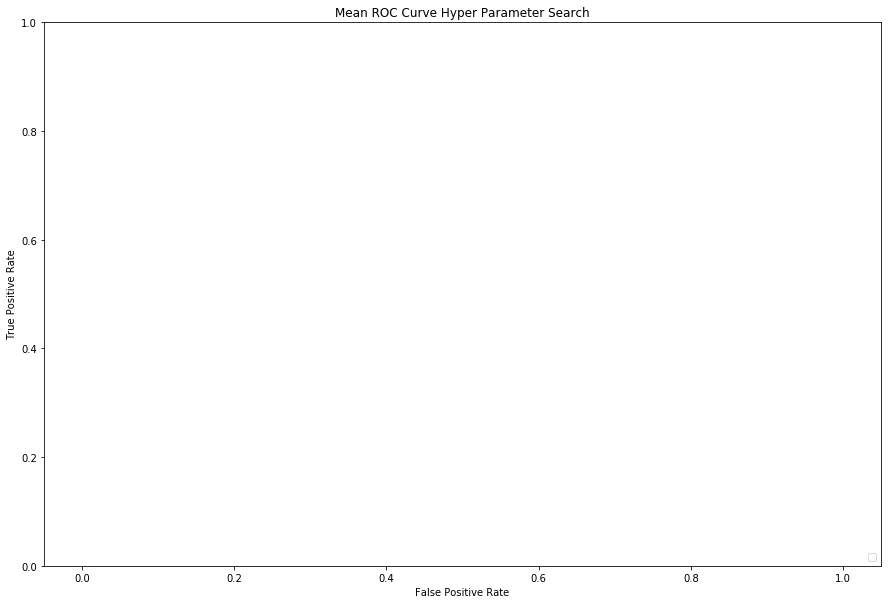

In [10]:
# Run classifier with cross-validation and plot ROC curves
seeds = [0]
sigmas = [0.01, 0.05, 0.1]
nus = [0.05, 0.1]
#base_fpr, base_tpr, base_auc = base_roc2(Strain, Ytrain, Stest, Ytest)
plt.figure(figsize=(15,10))
for nu in nus:
    for sigma in sigmas:
        
        mean_fpr, tprs, aucs = boostrap_roc2(Strain, Ytrain, Stest, Ytest, seeds, sigma, nu)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        #plot_mean_ROC_search(mean_fpr, tprs, aucs, sigma, nu)
        print('AUC for sigma = %0.2f, nu = %0.2f is %0.2f'%(sigma,nu,mean_auc))
#plot_mean_and_CI(mean_fpr, tprs, aucs, base_fpr, base_tpr, base_auc)
plt.xlim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve Hyper Parameter Search')
plt.legend(loc="lower right")
plt.show()